In [2]:
import os 
import xarray as xr
import rioxarray as rio
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from shapely.geometry import Polygon, Point, MultiPolygon

In [3]:
# CONSULTANDO ENDEREÇO DOS ARQUIVOS NA PASTA DO DRIVE
url = '/mnt/c/Users/Marcio/Desktop/Sat Data/2010'

lista = os.listdir(url)

lista = lista[1:]

lista

['02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

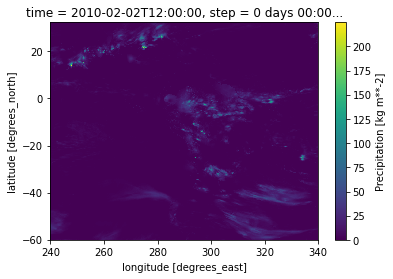

In [4]:
filename = '/mnt/c/Users/Marcio/Desktop/Sat Data/2010/02/MERGE_CPTEC_20100202.grib2'

cptec_file = xr.open_dataset(filename,engine = 'cfgrib')

cptec_file.prec.plot()

In [26]:
cptec_file

<xarray.Dataset>
Dimensions:     (latitude: 924, longitude: 1001)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 -60.05 -59.95 -59.85 ... 32.05 32.15 32.25
  * longitude   (longitude) float64 239.9 240.0 240.1 ... 339.8 339.9 340.0
    valid_time  datetime64[ns] ...
Data variables:
    prec        (latitude, longitude) float32 ...
    prmsl       (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             consensus
    GRIB_centreDescription:  Consensus
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Consensus
    history:                 2022-04-27T07:08 GRIB to CDM+CF via cfgrib-0.9.1...

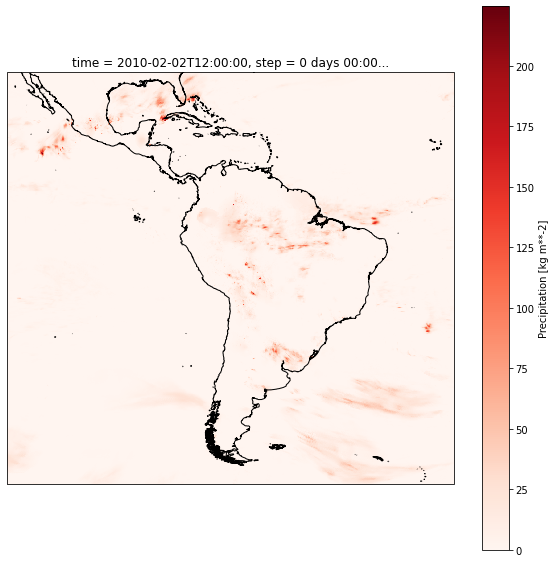

In [5]:
# melhorando o plot

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree()) #robinson for axes???
ax.coastlines(resolution="10m")
# plot = cptec_file.prec.plot(
#     cmap=plt.cm.coolwarm, transform=ccrs.PlateCarree(), cbar_kwargs={"shrink": 0.6}
plot = cptec_file.prec.plot(
    cmap=plt.cm.Reds 
)

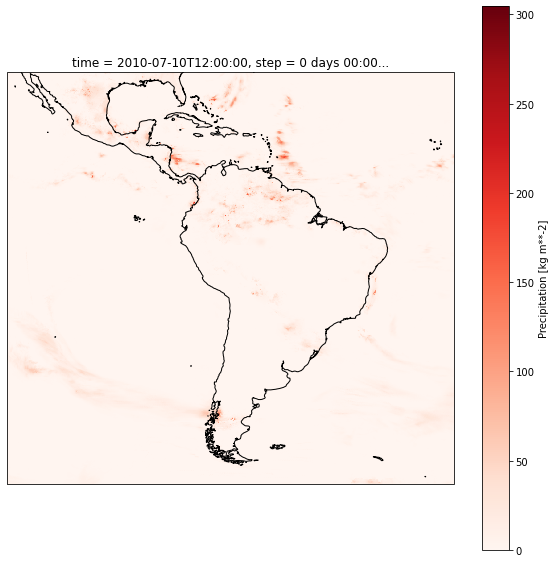

In [6]:
# now will open the merged file and do the same 

filename = '/mnt/c/Users/Marcio/Desktop/Sat Data/2010/07/july.grib2'
merged = xr.load_dataset(filename,engine = 'cfgrib') # note I changed to **load_dataset**
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree()) #robinson for axes???
ax.coastlines(resolution="50m")
# plot = cptec_file.prec.plot(
#     cmap=plt.cm.coolwarm, transform=ccrs.PlateCarree(), cbar_kwargs={"shrink": 0.6}
plot = merged.prec[9].plot(
    cmap=plt.cm.Reds 
)


In [7]:
for v in merged:
    print("{}, {}, {}".format(v, merged[v].attrs["long_name"], merged[v].attrs["units"]))

prec, Precipitation, kg m**-2
prmsl, Pressure reduced to MSL, Pa


In [11]:
# getting precipitation and converting to a DF

my_prec = merged.get('prec')
df_prec = my_prec.to_dataframe()

lats = df_prec.index.get_level_values('latitude')
longs = df_prec.index.get_level_values('longitude')
time = df_prec.index.get_level_values('time')

df_prec["longitude"] = longs
df_prec["latitude"] = lats
df_prec['time'] = time


In [29]:
df_prec = df_prec[['latitude','longitude','time','prec']]

#filtering a location
min_lat = -23.50
max_lat = -23.35
min_long = 249.20
max_long = 249.30

lat_filter = (df_prec["latitude"] >= min_lat) & (df_prec["latitude"] <= max_lat)
lon_filter = (df_prec["longitude"] >= min_long) & (df_prec["longitude"] <= max_long)

df_prec = df_prec.loc[lat_filter & lon_filter]


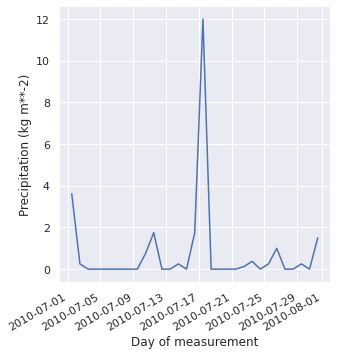

In [28]:
import seaborn as sns
sns.set_theme(style="darkgrid")
my_plot = sns.relplot(x="time", y="prec", kind = 'line', data=df_prec)
my_plot.figure.autofmt_xdate()
my_plot.set_axis_labels("Day of measurement", "Precipitation (kg m**-2)")


# Código original do Wallace / João


In [35]:
# CONSTRUINDO DATAFRAME PANDAS
list_frames = []

for filename in lista:
  print('start',filename)
  nc_file = xr.open_dataset(url + filename)
  xco2 = nc_file[[
    'longitude',
    'latitude',
    'xco2',
    'time',
    'vertex_longitude',
    'vertex_latitude'
  ]]

  xco2.rio.set_crs("epsg:4326")

  df = xco2.to_dataframe()

  df = df.reset_index()

  df['vertices'] = df['vertices'].astype(str)

  dfp = pd.pivot_table(df,
                     index=['sounding_id', 'time', 'latitude', 'longitude', 'xco2'],
                     columns='vertices',
                     values=['vertex_longitude', 'vertex_latitude'])

  dfp = dfp.reset_index()

  dfp.columns = dfp.columns.map('_'.join).str.strip('_')

  dfp['geometry'] = dfp.apply(
      lambda s: Polygon(shell=[
          Point(s.vertex_longitude_1, s.vertex_latitude_1),
          Point(s.vertex_longitude_2, s.vertex_latitude_2),
          Point(s.vertex_longitude_3, s.vertex_latitude_3),
          Point(s.vertex_longitude_4, s.vertex_latitude_4),
          Point(s.vertex_longitude_1, s.vertex_latitude_1)
      ]),
      axis=1
  )

  list_frames.append(dfp)
  # print('end',filename)

  # obs: no dia 19/04/2022 as 19:00 demorou um pouco mais de um minuto cada tabela
  # 24 arquivos demoraram 24 min e 39 segundos
print('the end')

frame = pd.concat(list_frames, axis=0, ignore_index=True)

frame

start oco2_LtCO2_200729_B10206Ar_210920055911s.nc4
end oco2_LtCO2_200729_B10206Ar_210920055911s.nc4
start oco2_LtCO2_200731_B10206Ar_210920181257s.nc4
end oco2_LtCO2_200731_B10206Ar_210920181257s.nc4
start oco2_LtCO2_200728_B10206Ar_210920055619s.nc4
end oco2_LtCO2_200728_B10206Ar_210920055619s.nc4
start oco2_LtCO2_200726_B10206Ar_210920055119s.nc4
end oco2_LtCO2_200726_B10206Ar_210920055119s.nc4
start oco2_LtCO2_200725_B10206Ar_210920054827s.nc4
end oco2_LtCO2_200725_B10206Ar_210920054827s.nc4
start oco2_LtCO2_200724_B10206Ar_210920054645s.nc4
end oco2_LtCO2_200724_B10206Ar_210920054645s.nc4
start oco2_LtCO2_200723_B10206Ar_210920054327s.nc4
end oco2_LtCO2_200723_B10206Ar_210920054327s.nc4
start oco2_LtCO2_200722_B10206Ar_210920054144s.nc4
end oco2_LtCO2_200722_B10206Ar_210920054144s.nc4
start oco2_LtCO2_200720_B10206Ar_210920053632s.nc4
end oco2_LtCO2_200720_B10206Ar_210920053632s.nc4
start oco2_LtCO2_200719_B10206Ar_210920053239s.nc4
end oco2_LtCO2_200719_B10206Ar_210920053239s.nc4


,sounding_id,time,latitude,longitude,xco2,vertex_latitude_1,vertex_latitude_2,vertex_latitude_3,vertex_latitude_4,vertex_longitude_1,vertex_longitude_2,vertex_longitude_3,vertex_longitude_4,geometry
0,2.020073e+15,2020-07-29 00:01:35.562024448,-15.794430,-155.648911,411.838867,-15.805361,-15.786860,-15.785495,-15.803993,-155.639908,-155.643661,-155.657928,-155.654175,POLYGON ((-155.63990783691406 -15.805360794067...
1,2.020073e+15,2020-07-29 00:01:35.894993664,-15.775892,-155.652679,413.520569,-15.786822,-15.768320,-15.766958,-15.785458,-155.643677,-155.647430,-155.661697,-155.657944,POLYGON ((-155.6436767578125 -15.7868223190307...
2,2.020073e+15,2020-07-29 00:01:35.921024768,-15.774675,-155.667297,416.242371,-15.785896,-15.767397,-15.765958,-15.784453,-155.657898,-155.661652,-155.676559,-155.672806,POLYGON ((-155.65789794921875 -15.785896301269...
3,2.020073e+15,2020-07-29 00:01:35.948021248,-15.773335,-155.682022,412.165100,-15.784738,-15.766241,-15.764800,-15.783294,-155.672775,-155.676514,-155.691498,-155.687759,POLYGON ((-155.6727752685547 -15.7847375869750...
4,2.020073e+15,2020-07-29 00:01:35.975017472,-15.771869,-155.696808,412.683563,-15.783422,-15.764929,-15.763486,-15.781976,-155.687637,-155.691391,-155.706284,-155.702545,POLYGON ((-155.68763732910156 -15.783422470092...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4264102,2.020070e+15,2020-07-01 23:12:00.696003584,79.512726,141.683578,411.662689,79.510460,79.514725,79.519737,79.515427,141.679214,141.584610,141.673630,141.768341,POLYGON ((141.67921447753906 79.51045989990234...
4264103,2.020070e+15,2020-07-01 23:12:00.723000064,79.517418,141.774963,403.737549,79.515190,79.519501,79.524567,79.520218,141.770370,141.675659,141.766617,141.861435,POLYGON ((141.77037048339844 79.51519012451172...
4264104,2.020070e+15,2020-07-01 23:12:00.748990720,79.521957,141.867172,405.074493,79.519684,79.524033,79.528954,79.524567,141.861908,141.767090,141.856598,141.951523,POLYGON ((141.86190795898438 79.51968383789062...
4264105,2.020070e+15,2020-07-01 23:12:01.056009728,79.521828,141.679138,416.919342,79.519508,79.523918,79.529015,79.524574,141.675461,141.579315,141.670303,141.766418,"POLYGON ((141.6754608154297 79.5195083618164, ..."


In [36]:
table = frame

table.pop('vertex_longitude_1')
table.pop('vertex_longitude_2')
table.pop('vertex_longitude_3')
table.pop('vertex_longitude_4')
table.pop('vertex_latitude_1')
table.pop('vertex_latitude_2')
table.pop('vertex_latitude_3')
table.pop('vertex_latitude_4')
table.pop('longitude')
table.pop('latitude')
table

,sounding_id,time,xco2,geometry
0,2.020073e+15,2020-07-29 00:01:35.562024448,411.838867,POLYGON ((-155.63990783691406 -15.805360794067...
1,2.020073e+15,2020-07-29 00:01:35.894993664,413.520569,POLYGON ((-155.6436767578125 -15.7868223190307...
2,2.020073e+15,2020-07-29 00:01:35.921024768,416.242371,POLYGON ((-155.65789794921875 -15.785896301269...
3,2.020073e+15,2020-07-29 00:01:35.948021248,412.165100,POLYGON ((-155.6727752685547 -15.7847375869750...
4,2.020073e+15,2020-07-29 00:01:35.975017472,412.683563,POLYGON ((-155.68763732910156 -15.783422470092...
...,...,...,...,...
4264102,2.020070e+15,2020-07-01 23:12:00.696003584,411.662689,POLYGON ((141.67921447753906 79.51045989990234...
4264103,2.020070e+15,2020-07-01 23:12:00.723000064,403.737549,POLYGON ((141.77037048339844 79.51519012451172...
4264104,2.020070e+15,2020-07-01 23:12:00.748990720,405.074493,POLYGON ((141.86190795898438 79.51968383789062...
4264105,2.020070e+15,2020-07-01 23:12:01.056009728,416.919342,"POLYGON ((141.6754608154297 79.5195083618164, ..."


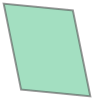

In [39]:
table['geometry'][4]

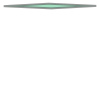

In [40]:
table['geometry'][4264104]

In [44]:
table['time'] = table['time'].astype(str)
table

,sounding_id,time,xco2,geometry
0,2.020073e+15,2020-07-29 00:01:35.562024448,411.838867,POLYGON ((-155.63990783691406 -15.805360794067...
1,2.020073e+15,2020-07-29 00:01:35.894993664,413.520569,POLYGON ((-155.6436767578125 -15.7868223190307...
2,2.020073e+15,2020-07-29 00:01:35.921024768,416.242371,POLYGON ((-155.65789794921875 -15.785896301269...
3,2.020073e+15,2020-07-29 00:01:35.948021248,412.165100,POLYGON ((-155.6727752685547 -15.7847375869750...
4,2.020073e+15,2020-07-29 00:01:35.975017472,412.683563,POLYGON ((-155.68763732910156 -15.783422470092...
...,...,...,...,...
4264102,2.020070e+15,2020-07-01 23:12:00.696003584,411.662689,POLYGON ((141.67921447753906 79.51045989990234...
4264103,2.020070e+15,2020-07-01 23:12:00.723000064,403.737549,POLYGON ((141.77037048339844 79.51519012451172...
4264104,2.020070e+15,2020-07-01 23:12:00.748990720,405.074493,POLYGON ((141.86190795898438 79.51968383789062...
4264105,2.020070e+15,2020-07-01 23:12:01.056009728,416.919342,"POLYGON ((141.6754608154297 79.5195083618164, ..."


In [45]:
gdf = gpd.GeoDataFrame(table, geometry='geometry', crs="EPSG:4326")

gdf

,sounding_id,time,xco2,geometry
0,2.020073e+15,2020-07-29 00:01:35.562024448,411.838867,"POLYGON ((-155.63991 -15.80536, -155.64366 -15..."
1,2.020073e+15,2020-07-29 00:01:35.894993664,413.520569,"POLYGON ((-155.64368 -15.78682, -155.64743 -15..."
2,2.020073e+15,2020-07-29 00:01:35.921024768,416.242371,"POLYGON ((-155.65790 -15.78590, -155.66165 -15..."
3,2.020073e+15,2020-07-29 00:01:35.948021248,412.165100,"POLYGON ((-155.67278 -15.78474, -155.67651 -15..."
4,2.020073e+15,2020-07-29 00:01:35.975017472,412.683563,"POLYGON ((-155.68764 -15.78342, -155.69139 -15..."
...,...,...,...,...
4264102,2.020070e+15,2020-07-01 23:12:00.696003584,411.662689,"POLYGON ((141.67921 79.51046, 141.58461 79.514..."
4264103,2.020070e+15,2020-07-01 23:12:00.723000064,403.737549,"POLYGON ((141.77037 79.51519, 141.67566 79.519..."
4264104,2.020070e+15,2020-07-01 23:12:00.748990720,405.074493,"POLYGON ((141.86191 79.51968, 141.76709 79.524..."
4264105,2.020070e+15,2020-07-01 23:12:01.056009728,416.919342,"POLYGON ((141.67546 79.51951, 141.57932 79.523..."


KeyboardInterrupt: ignored

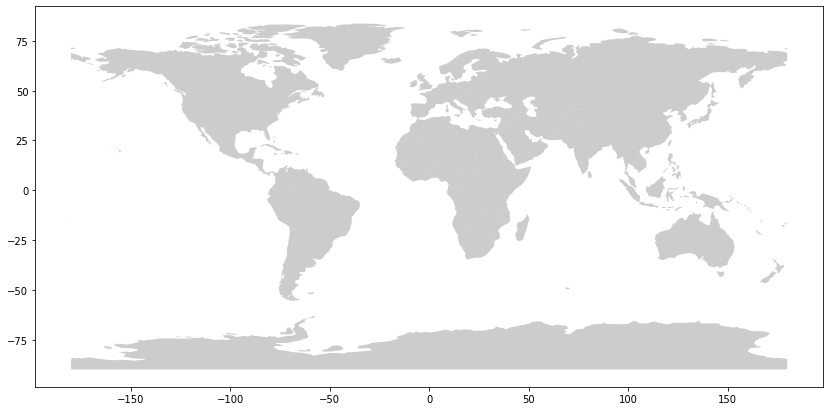

In [50]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(18, 7))
world.plot(ax=ax, alpha=0.4, color='grey')
gdf.plot(column='xco2', ax=ax, legend=True)

plt.title('xco2')

In [51]:
table.set_index('time')

,sounding_id,xco2,geometry
time,,,
2020-07-29 00:01:35.562024448,2.020073e+15,411.838867,"POLYGON ((-155.63991 -15.80536, -155.64366 -15..."
2020-07-29 00:01:35.894993664,2.020073e+15,413.520569,"POLYGON ((-155.64368 -15.78682, -155.64743 -15..."
2020-07-29 00:01:35.921024768,2.020073e+15,416.242371,"POLYGON ((-155.65790 -15.78590, -155.66165 -15..."
2020-07-29 00:01:35.948021248,2.020073e+15,412.165100,"POLYGON ((-155.67278 -15.78474, -155.67651 -15..."
2020-07-29 00:01:35.975017472,2.020073e+15,412.683563,"POLYGON ((-155.68764 -15.78342, -155.69139 -15..."
...,...,...,...
2020-07-01 23:12:00.696003584,2.020070e+15,411.662689,"POLYGON ((141.67921 79.51046, 141.58461 79.514..."
2020-07-01 23:12:00.723000064,2.020070e+15,403.737549,"POLYGON ((141.77037 79.51519, 141.67566 79.519..."
2020-07-01 23:12:00.748990720,2.020070e+15,405.074493,"POLYGON ((141.86191 79.51968, 141.76709 79.524..."


In [52]:
table.to_csv(url + 'scripts/csv-v1/xco2_2020_julho-v3.csv')
# gdf.to_csv(url + 'scripts/csv-v1/xco2_2020_julho-v2.csv')
# gdf.to_file(url + 'scripts/shp-v1/xco2_2020_julho-v1.shp')